In [44]:
import torch
from conex import Conv2dFilter, SqueezeTransform, Intensity2Latency, Poisson
from matplotlib import pyplot as plt
from PIL import Image
from conex.helpers.filters import DoGFilter, GaborFilter
from torchvision.transforms import transforms

from src.decoders import Latency2Intensity, PoissonDecoder
from src.plots.encoders import add_encoder_raster_plot
from src.plots.utils import plot_kernel_3d
from src.transforms import MinMaxNormalizer

# Analyzing filters and their parameters

### a) DoG Filter
Let's first plot the filters themselves

In [2]:
# Create DoG Filter
dog_kernel_low = DoGFilter(30, 3, 6, zero_mean=True, one_sum=True)

dog_kernel_high = DoGFilter(30, 4, 8, zero_mean=True, one_sum=True)

dog_kernel_off = DoGFilter(30, 6, 3, zero_mean=True, one_sum=True)

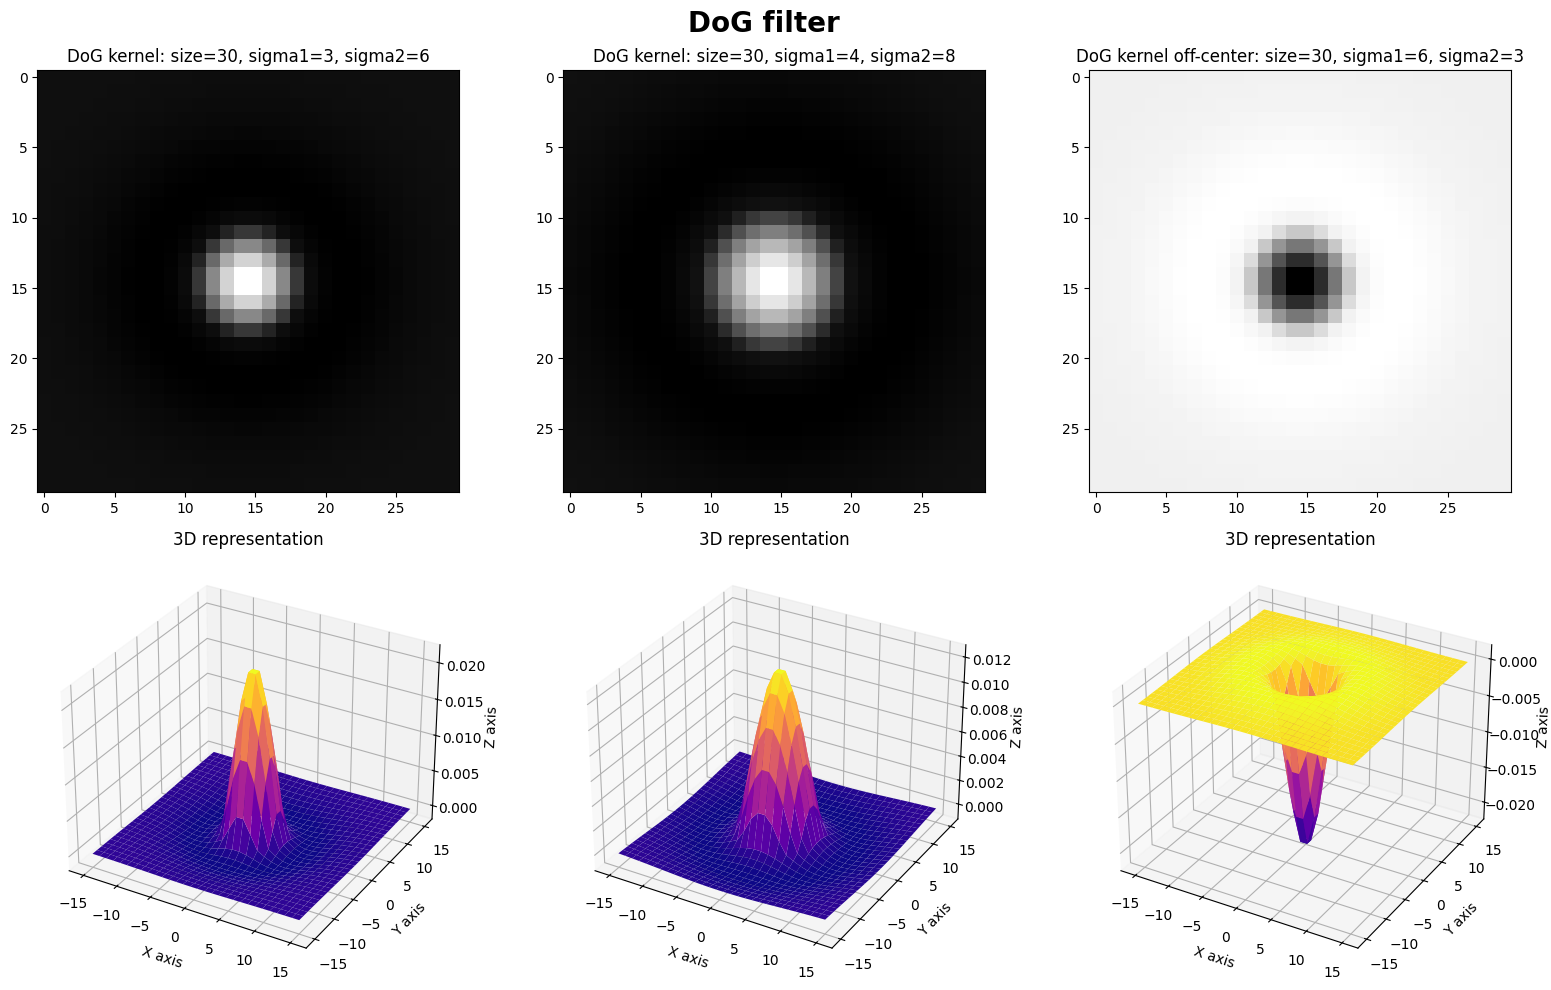

In [3]:
fig = plt.figure(figsize=(16, 10))

ax1 = fig.add_subplot(2, 3, 1)
ax1.imshow(dog_kernel_low, cmap='gray')
ax1.set_title(f"DoG kernel: size=30, sigma1=3, sigma2=6")

ax2 = fig.add_subplot(2, 3, 2)
ax2.imshow(dog_kernel_high, cmap='gray')
ax2.set_title(f"DoG kernel: size=30, sigma1=4, sigma2=8")

ax3 = fig.add_subplot(2, 3, 3)
ax3.imshow(dog_kernel_off, cmap='gray')
ax3.set_title(f"DoG kernel off-center: size=30, sigma1=6, sigma2=3")

ax4 = fig.add_subplot(2, 3, 4, projection='3d')
plot_kernel_3d(ax=ax4, kernel=dog_kernel_low, cmap='plasma')
ax4.set_title(f"3D representation")

ax5 = fig.add_subplot(2, 3, 5, projection='3d')
plot_kernel_3d(ax=ax5, kernel=dog_kernel_high, cmap='plasma')
ax5.set_title(f"3D representation")

ax6 = fig.add_subplot(2, 3, 6, projection='3d')
plot_kernel_3d(ax=ax6, kernel=dog_kernel_off, cmap='plasma')
ax6.set_title(f"3D representation")

fig.suptitle("DoG filter", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("../report/plots/part1-DoG-Kernel.pdf")
plt.show()

### b) Gabor Filter

In [7]:
# Create Gabor Filter
# gabor_kernel = GaborFilter(size=15, labda=7.0, theta=np.pi/6, sigma=4.0, gamma=0.4, zero_mean=True, one_sum=True).unsqueeze(0).unsqueeze(0)
gabor_kernel_base = GaborFilter(size=31, labda=10.0, theta=0, sigma=5.0, gamma=1.0, zero_mean=True, one_sum=True)
gabor_kernel_labda = GaborFilter(size=31, labda=20.0, theta=0, sigma=5.0, gamma=1.0, zero_mean=True, one_sum=True)
gabor_kernel_theta = GaborFilter(size=31, labda=10.0, theta=torch.pi / 4, sigma=5.0, gamma=1.0, zero_mean=True, one_sum=True)
gabor_kernel_sigma = GaborFilter(size=31, labda=10.0, theta=0, sigma=8.0, gamma=1.0, zero_mean=True, one_sum=True)
gabor_kernel_gamma = GaborFilter(size=31, labda=10.0, theta=0, sigma=5.0, gamma=0.5, zero_mean=True, one_sum=True)


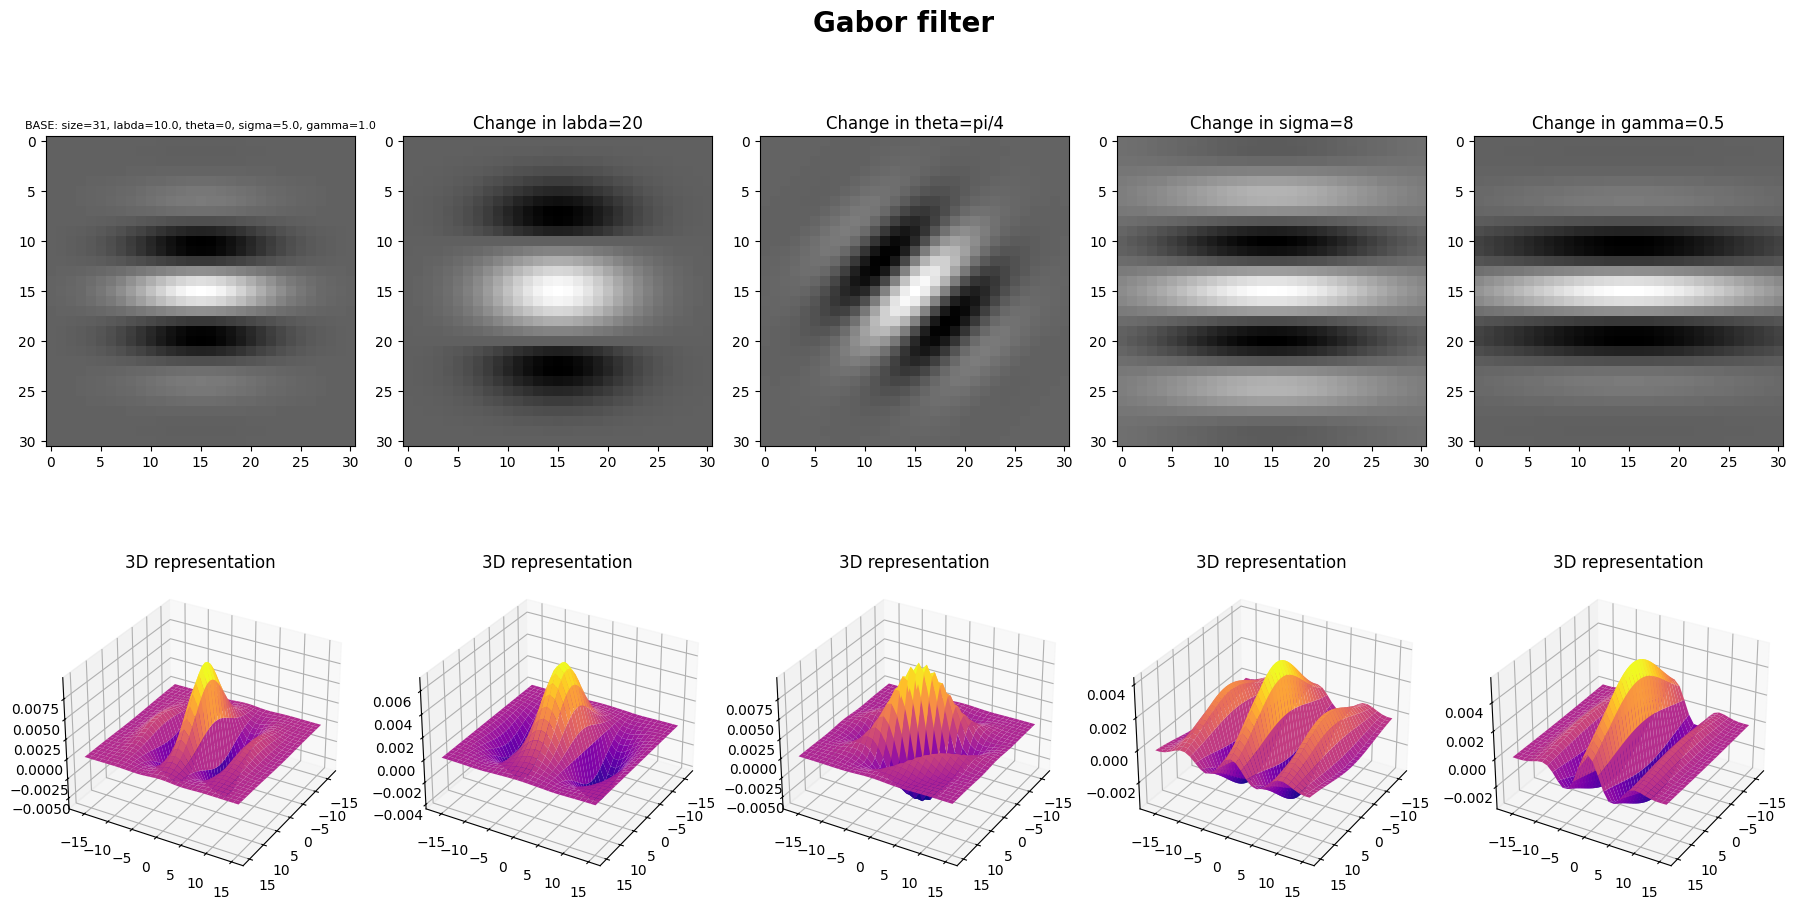

In [8]:
fig = plt.figure(figsize=(18, 10))

ax1 = fig.add_subplot(2, 5, 1)
ax1.imshow(gabor_kernel_base, cmap='gray')
ax1.set_title(f"BASE: size=31, labda=10.0, theta=0, sigma=5.0, gamma=1.0", fontsize=8)

ax2 = fig.add_subplot(2, 5, 2)
ax2.imshow(gabor_kernel_labda, cmap='gray')
ax2.set_title(f"Change in labda=20")

ax3 = fig.add_subplot(2, 5, 3)
ax3.imshow(gabor_kernel_theta, cmap='gray')
ax3.set_title(f"Change in theta=pi/4")

ax4 = fig.add_subplot(2, 5, 4)
ax4.imshow(gabor_kernel_sigma, cmap='gray')
ax4.set_title(f"Change in sigma=8")

ax5 = fig.add_subplot(2, 5, 5)
ax5.imshow(gabor_kernel_gamma, cmap='gray')
ax5.set_title(f"Change in gamma=0.5")

ax6 = fig.add_subplot(2, 5, 6, projection='3d', elev=30, azim=30)
plot_kernel_3d(ax=ax6, kernel=gabor_kernel_base, cmap='plasma', ax_label=False)
ax6.set_title(f"3D representation")

ax7 = fig.add_subplot(2, 5, 7, projection='3d', elev=30, azim=30)
plot_kernel_3d(ax=ax7, kernel=gabor_kernel_labda, cmap='plasma', ax_label=False)
ax7.set_title(f"3D representation")

ax8 = fig.add_subplot(2, 5, 8, projection='3d', elev=30, azim=30)
plot_kernel_3d(ax=ax8, kernel=gabor_kernel_theta, cmap='plasma', ax_label=False)
ax8.set_title(f"3D representation")

ax9 = fig.add_subplot(2, 5, 9, projection='3d', elev=30, azim=30)
plot_kernel_3d(ax=ax9, kernel=gabor_kernel_sigma, cmap='plasma', ax_label=False)
ax9.set_title(f"3D representation")

ax10 = fig.add_subplot(2, 5, 10, projection='3d', elev=30, azim=30)
plot_kernel_3d(ax=ax10, kernel=gabor_kernel_gamma, cmap='plasma', ax_label=False)
ax10.set_title(f"3D representation")

fig.suptitle("Gabor filter", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("../report/plots/part1-Gabor-Kernel.pdf")
plt.show()

# Applying filters on images

a) DoG filter:

In [10]:
# Read a PIL image
img = Image.open('../dataset/samples/1.tif').convert('L')  # Convert to grayscale
transform = transforms.Compose([
    transforms.ToTensor()  # Converts to Tensor, scales to [0, 1] float
])
img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0)  # Add batch and channel dimensions

In [11]:
# Create DoG kernels
dog_kernel_low = DoGFilter(15, 1, 2, zero_mean=True, one_sum=True).unsqueeze(0).unsqueeze(0)
dog_kernel_high = DoGFilter(15, 2, 4, zero_mean=True, one_sum=True).unsqueeze(0).unsqueeze(0)

In [12]:
# Create DoG Filters
dog_filter_low = Conv2dFilter(dog_kernel_low, padding='same')
dog_filter_high = Conv2dFilter(dog_kernel_high, padding='same')

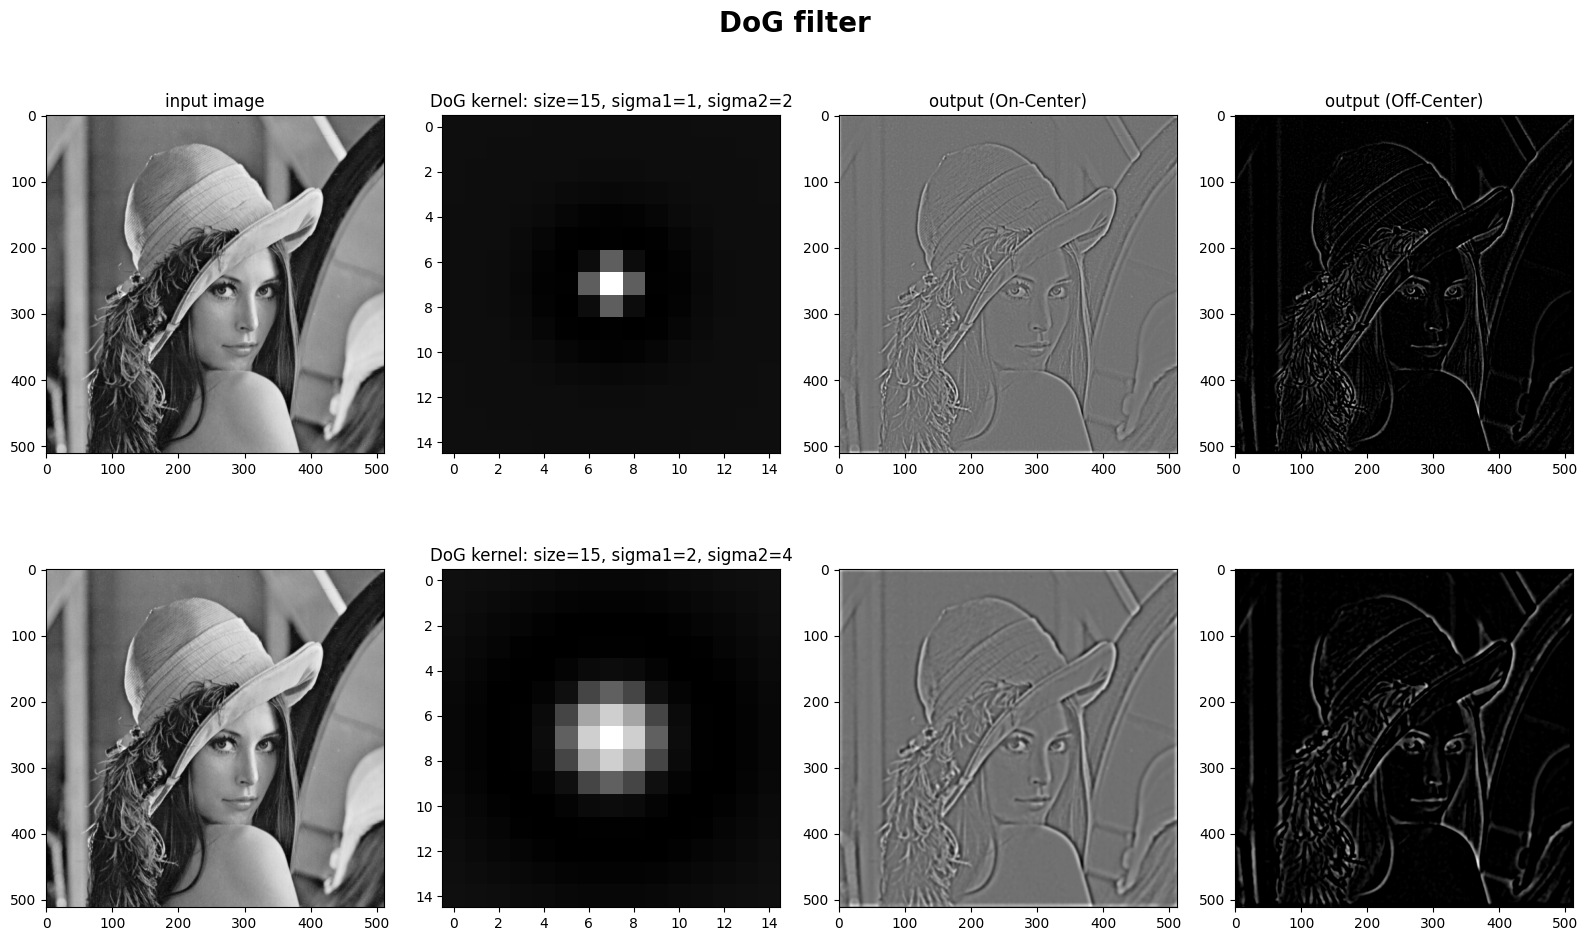

In [13]:
fig = plt.figure(figsize=(16, 10))

ax1 = fig.add_subplot(2, 4, 1)
ax1.imshow(img_tensor.squeeze(0).squeeze(0), cmap='gray')
ax1.set_title("input image")

ax2 = fig.add_subplot(2, 4, 2)
ax2.imshow(dog_kernel_low.squeeze(0).squeeze(0), cmap='gray')
ax2.set_title(f"DoG kernel: size=15, sigma1=1, sigma2=2")

ax3 = fig.add_subplot(2, 4, 3)
ax3.imshow( dog_filter_low(img_tensor).squeeze(0).squeeze(0), cmap='gray')
ax3.set_title("output (On-Center)")

ax4 = fig.add_subplot(2, 4, 4)
ax4.imshow( Conv2dFilter(-1*dog_kernel_low, padding='same')(img_tensor).clamp(0, 1).squeeze(0).squeeze(0), cmap='gray')
ax4.set_title("output (Off-Center)")

ax5 = fig.add_subplot(2, 4, 5)
ax5.imshow(img_tensor.squeeze(0).squeeze(0), cmap='gray')
# ax5.set_title("input image")

ax6 = fig.add_subplot(2, 4, 6)
ax6.imshow(dog_kernel_high.squeeze(0).squeeze(0), cmap='gray')
ax6.set_title(f"DoG kernel: size=15, sigma1=2, sigma2=4")

ax7 = fig.add_subplot(2, 4, 7)
ax7.imshow(dog_filter_high(img_tensor).squeeze(0).squeeze(0), cmap='gray')
# ax7.set_title("output (On-Center)")

ax8 = fig.add_subplot(2, 4, 8)
ax8.imshow( Conv2dFilter(-1*dog_kernel_high, padding='same')(img_tensor).clamp(0, 1).squeeze(0).squeeze(0), cmap='gray')
# ax8.set_title("output (Off-Center)")

fig.suptitle("DoG filter", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("../report/plots/part1-DoG-convolution.pdf")
plt.show()

b) Gabor filter:

In [14]:
gabor_filter_base = Conv2dFilter(gabor_kernel_base.unsqueeze(0).unsqueeze(0), padding='same')
gabor_filter_labda = Conv2dFilter(gabor_kernel_labda.unsqueeze(0).unsqueeze(0), padding='same')
gabor_filter_theta = Conv2dFilter(gabor_kernel_theta.unsqueeze(0).unsqueeze(0), padding='same')
gabor_filter_sigma = Conv2dFilter(gabor_kernel_sigma.unsqueeze(0).unsqueeze(0), padding='same')
gabor_filter_gamma = Conv2dFilter(gabor_kernel_gamma.unsqueeze(0).unsqueeze(0), padding='same')
gabor_kernels = [gabor_kernel_base, gabor_kernel_labda, gabor_kernel_theta, gabor_kernel_sigma, gabor_kernel_gamma]
gabor_filters = [gabor_filter_base, gabor_filter_labda, gabor_filter_theta, gabor_filter_sigma, gabor_filter_gamma]
gabor_titles = ['BASE: size=31, labda=10.0, theta=0, sigma=5.0, gamma=1.0', 'Change in labda=20', 'Change in theta=pi/4', 'Change in sigma=8', 'Change in gamma=0.5']

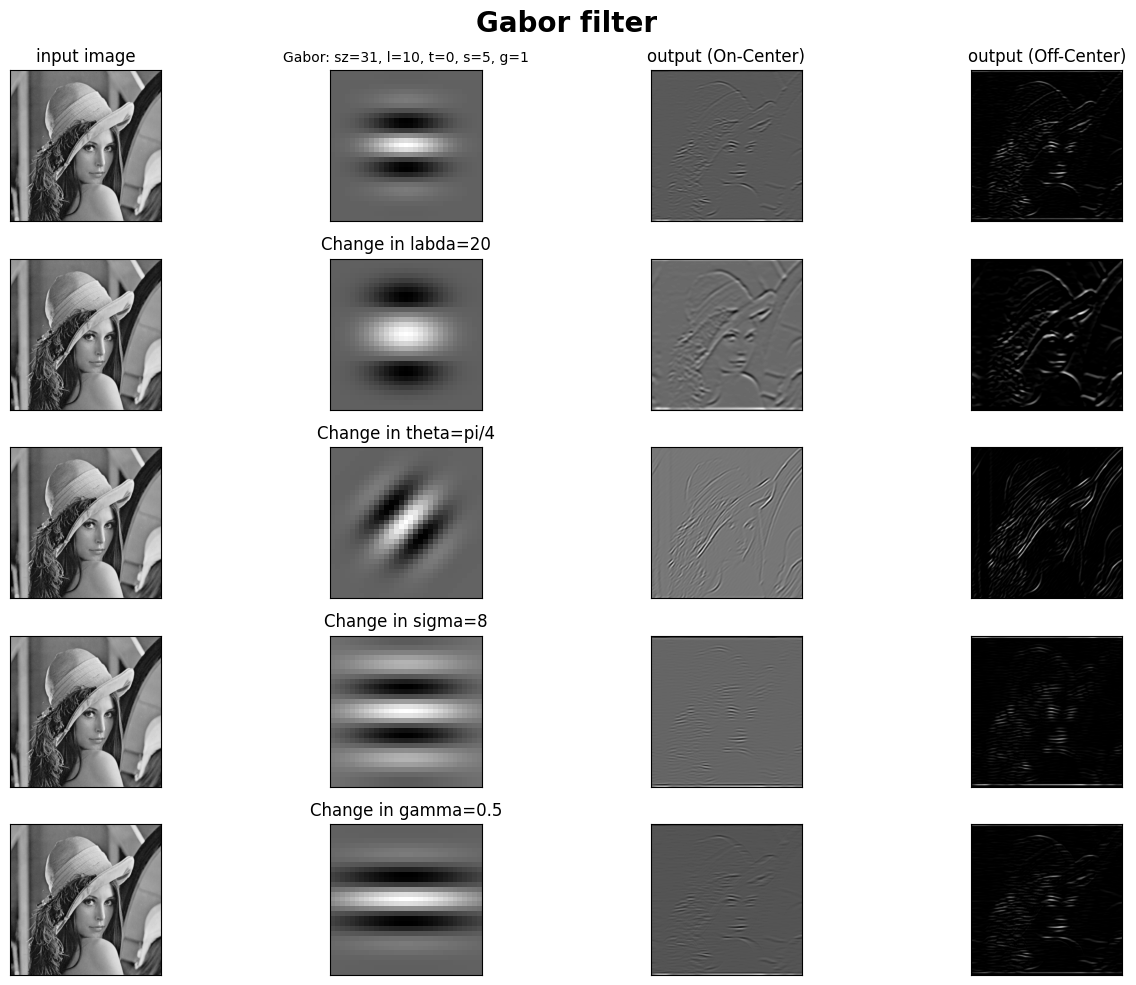

In [15]:
fig = plt.figure(figsize=(14, 10))

for i in range(5):
    ax = fig.add_subplot(5, 4, 4 * i + 1)
    ax.imshow(img_tensor.squeeze(0).squeeze(0), cmap='gray')
    ax.set_title("input image") if i==0 else None
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = fig.add_subplot(5, 4, 4 * i + 2)
    ax.imshow(gabor_kernels[i].squeeze(0).squeeze(0), cmap='gray')
    ax.set_title("Gabor: sz=31, l=10, t=0, s=5, g=1", fontsize=10) if i==0 else ax.set_title(gabor_titles[i%5])
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = fig.add_subplot(5, 4, 4 * i + 3)
    ax.imshow(gabor_filters[i](img_tensor).squeeze(0).squeeze(0), cmap='gray')
    ax.set_title("output (On-Center)") if i==0 else None
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = fig.add_subplot(5, 4, 4 * i + 4)
    ax.imshow( Conv2dFilter(-1*gabor_kernels[i].unsqueeze(0).unsqueeze(0), padding='same')(img_tensor).clamp(0, 1).squeeze(0).squeeze(0), cmap='gray')
    ax.set_title("output (Off-Center)") if i==0 else None
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle("Gabor filter", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("../report/plots/part1-Gabor-convolution.pdf")
plt.show()

# 2) Now let's feed our dataset to a neuron group and see their spike

In [17]:
##################################################
# parameters
##################################################
INSTANCE_DURATION = 100
POISSON_RATIO = 5 / 100
SENSORY_SIZE_HEIGHT = 100
SENSORY_SIZE_WIDTH = 100  # Dataset's image size

### Let's first simulate a model in simple images(without filters)

# 1) Encode image using Time-to-First-Spike
### a) No filter

In [18]:
transformation = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        # gabor_filter_high,
        transforms.Resize((SENSORY_SIZE_HEIGHT, SENSORY_SIZE_WIDTH)),
        SqueezeTransform(dim=0),
        Intensity2Latency(time_window=INSTANCE_DURATION),
    ]
)
encoded_ttfs = transformation(img)

# plt.imshow(encoded_img[9], cmap='gray')

### b) DoG filter

In [19]:
transformation = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        dog_filter_low,
        MinMaxNormalizer(),
        transforms.Resize((SENSORY_SIZE_HEIGHT, SENSORY_SIZE_WIDTH)),
        SqueezeTransform(dim=0),
        Intensity2Latency(time_window=INSTANCE_DURATION),
        # TimeToFirstSpike(time_window=INSTANCE_DURATION, theta=0.01),
    ]
)
encoded_ttfs_dog = transformation(img)

### c) Gabor Filter

In [20]:
transformation = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        gabor_filter_base,
        MinMaxNormalizer(),
        transforms.Resize((SENSORY_SIZE_HEIGHT, SENSORY_SIZE_WIDTH)),
        SqueezeTransform(dim=0),
        Intensity2Latency(time_window=INSTANCE_DURATION),
        # TimeToFirstSpike(time_window=INSTANCE_DURATION, theta=0.01),
    ]
)
encoded_ttfs_gabor = transformation(img)

### Now let's increase the parameters of filters

In [21]:
transformation = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        dog_filter_high,
        MinMaxNormalizer(),
        transforms.Resize((SENSORY_SIZE_HEIGHT, SENSORY_SIZE_WIDTH)),
        SqueezeTransform(dim=0),
        Intensity2Latency(time_window=INSTANCE_DURATION),
        # TimeToFirstSpike(time_window=INSTANCE_DURATION, theta=0.01),
    ]
)
encoded_ttfs_dog_high = transformation(img)

In [22]:
transformation = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        gabor_filter_sigma,
        MinMaxNormalizer(),
        transforms.Resize((SENSORY_SIZE_HEIGHT, SENSORY_SIZE_WIDTH)),
        SqueezeTransform(dim=0),
        Intensity2Latency(time_window=INSTANCE_DURATION),
        # TimeToFirstSpike(time_window=INSTANCE_DURATION, theta=0.01),
    ]
)
encoded_ttfs_gabor_high = transformation(img)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


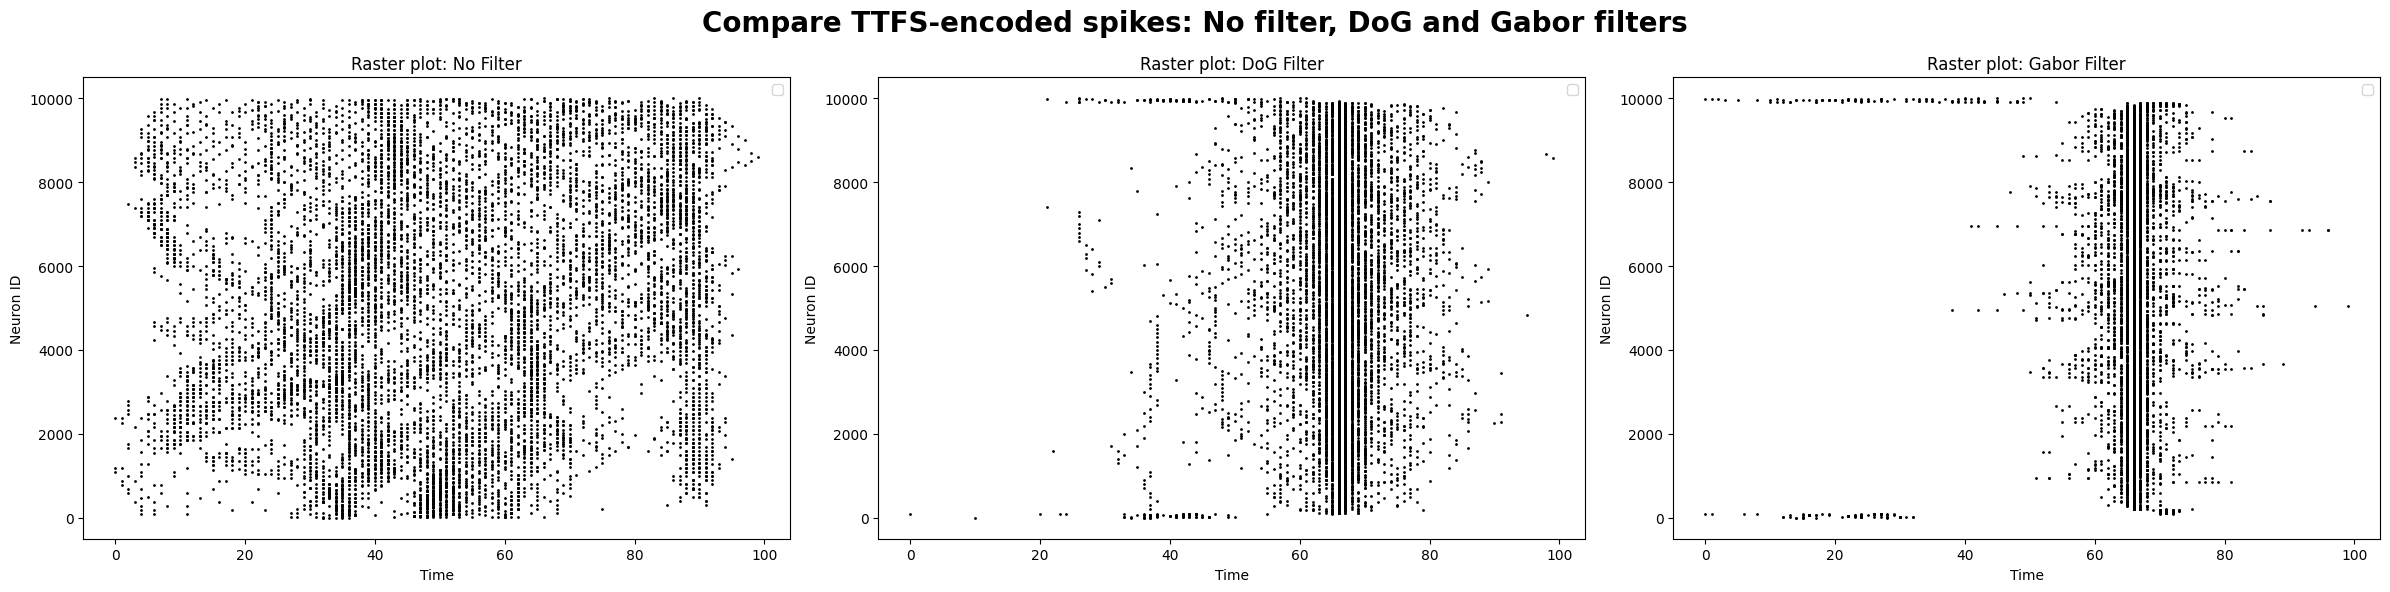

In [23]:
fig = plt.figure(figsize=(24, 6))

ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title('Raster plot: No Filter')
add_encoder_raster_plot(encoded_ttfs, ax1, s=1, color='black')

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title('Raster plot: DoG Filter')
add_encoder_raster_plot(encoded_ttfs_dog, ax2, s=1, color='black')

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title('Raster plot: Gabor Filter')
add_encoder_raster_plot(encoded_ttfs_gabor, ax3, s=1, color='black')

# ####### Add extra info #########
# ax4 = fig.add_subplot(2, 3, 4)
# ax4.axis("off")
# 
# ax5 = fig.add_subplot(2, 3, 5)
# ax5.set_title('Raster plot: DoG Filter')
# add_encoder_raster_plot(encoded_ttfs_dog_high, ax5, s=1, color='black')
# 
# ax6 = fig.add_subplot(2, 3, 6)
# ax6.set_title('Raster plot: Gabor Filter')
# add_encoder_raster_plot(encoded_ttfs_gabor_high, ax6, s=1, color='black')



fig.suptitle("Compare TTFS-encoded spikes: No filter, DoG and Gabor filters", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("../report/plots/part1-compare-ttfs-filters-spikes.png")
# plt.savefig("../report/plots/part1-compare-ttfs-filters-spikes.pdf")
plt.show()

# 2) Encode image using Poisson 
### a) No filter

In [25]:
transformation = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Resize((SENSORY_SIZE_HEIGHT, SENSORY_SIZE_WIDTH)),
        SqueezeTransform(dim=0),
        Poisson(time_window=INSTANCE_DURATION, ratio=POISSON_RATIO),
    ]
)
encoded_poisson = transformation(img)

In [26]:
transformation = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        dog_filter_low,
        MinMaxNormalizer(),
        transforms.Resize((SENSORY_SIZE_HEIGHT, SENSORY_SIZE_WIDTH)),
        SqueezeTransform(dim=0),
        Poisson(time_window=INSTANCE_DURATION, ratio=0.05),
    ]
)
encoded_poisson_dog = transformation(img)


In [27]:
transformation = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        gabor_filter_base,
        MinMaxNormalizer(),
        transforms.Resize((SENSORY_SIZE_HEIGHT, SENSORY_SIZE_WIDTH)),
        SqueezeTransform(dim=0),
        Poisson(time_window=INSTANCE_DURATION, ratio=POISSON_RATIO),
    ]
)
encoded_poisson_gabor = transformation(img)

### Now let's increase the parameters of filters

In [28]:
transformation = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        dog_filter_high,
        MinMaxNormalizer(),
        transforms.Resize((SENSORY_SIZE_HEIGHT, SENSORY_SIZE_WIDTH)),
        SqueezeTransform(dim=0),
        Poisson(time_window=INSTANCE_DURATION, ratio=POISSON_RATIO),
    ]
)
encoded_poisson_dog_high = transformation(img)

In [29]:
transformation = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        gabor_filter_sigma,
        MinMaxNormalizer(),
        transforms.Resize((SENSORY_SIZE_HEIGHT, SENSORY_SIZE_WIDTH)),
        SqueezeTransform(dim=0),
        Poisson(time_window=INSTANCE_DURATION, ratio=POISSON_RATIO),
    ]
)
encoded_poisson_gabor_high = transformation(img)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


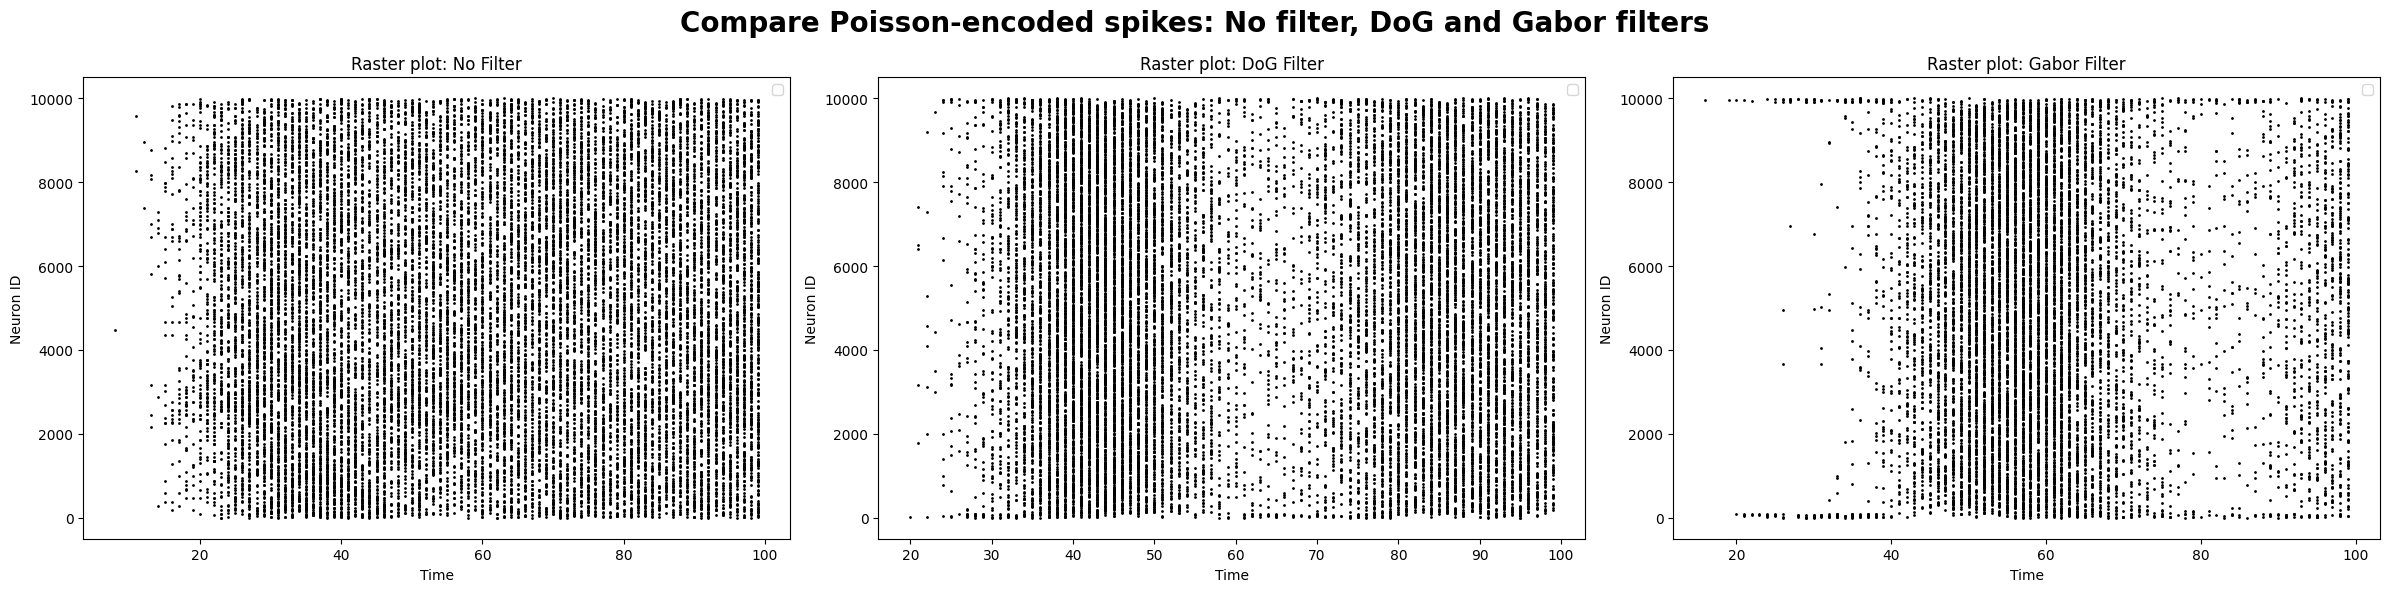

In [31]:
fig = plt.figure(figsize=(24, 6))

ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title('Raster plot: No Filter')
add_encoder_raster_plot(encoded_poisson, ax1, s=1, color='black')

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title('Raster plot: DoG Filter')
add_encoder_raster_plot(encoded_poisson_dog, ax2, s=1, color='black')

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title('Raster plot: Gabor Filter')
add_encoder_raster_plot(encoded_poisson_gabor, ax3, s=1, color='black')

# ####### Add extra info #########
# ax4 = fig.add_subplot(2, 3, 4)
# ax4.axis("off")
# 
# ax5 = fig.add_subplot(2, 3, 5)
# ax5.set_title('Raster plot: DoG Filter')
# add_encoder_raster_plot(encoded_poisson_dog_high, ax5, s=1, color='black')
# 
# ax6 = fig.add_subplot(2, 3, 6)
# ax6.set_title('Raster plot: Gabor Filter')
# add_encoder_raster_plot(encoded_poisson_gabor_high, ax6, s=1, color='black')



fig.suptitle("Compare Poisson-encoded spikes: No filter, DoG and Gabor filters", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("../report/plots/part1-compare-poisson-filters-spikes.pdf")
plt.savefig("../report/plots/part1-compare-poisson-filters-spikes.png")
plt.show()

# Reconstructing image from spikes

### a) Time-to-First-Spike

In [39]:
INSTANCE_DURATION = 5
ttfs_decoder = Latency2Intensity(time_window=INSTANCE_DURATION)

In [40]:
# Create DoG kernels
dog_kernel = DoGFilter(15, 1, 2, zero_mean=True, one_sum=True).unsqueeze(0).unsqueeze(0)
gabor_kernel = GaborFilter(size=31, labda=20.0, theta=0, sigma=5.0, gamma=1.0, zero_mean=True, one_sum=True).unsqueeze(0).unsqueeze(0)

# Create DoG Filters
dog_filter = Conv2dFilter(dog_kernel, padding='same')
gabor_filter = Conv2dFilter(gabor_kernel, padding='same')

In [41]:
transformation = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        dog_filter,
        MinMaxNormalizer(),
        transforms.Resize((512, 512)),
        SqueezeTransform(dim=0),
        Intensity2Latency(time_window=INSTANCE_DURATION),
        # TimeToFirstSpike(time_window=INSTANCE_DURATION, theta=0.01),
    ]
)
encoded_ttfs_dog = transformation(img)

In [42]:
transformation = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        gabor_filter,
        MinMaxNormalizer(),
        transforms.Resize((512, 512)),
        SqueezeTransform(dim=0),
        Intensity2Latency(time_window=INSTANCE_DURATION),
        # TimeToFirstSpike(time_window=INSTANCE_DURATION, theta=0.01),
    ]
)
encoded_ttfs_gabor = transformation(img)

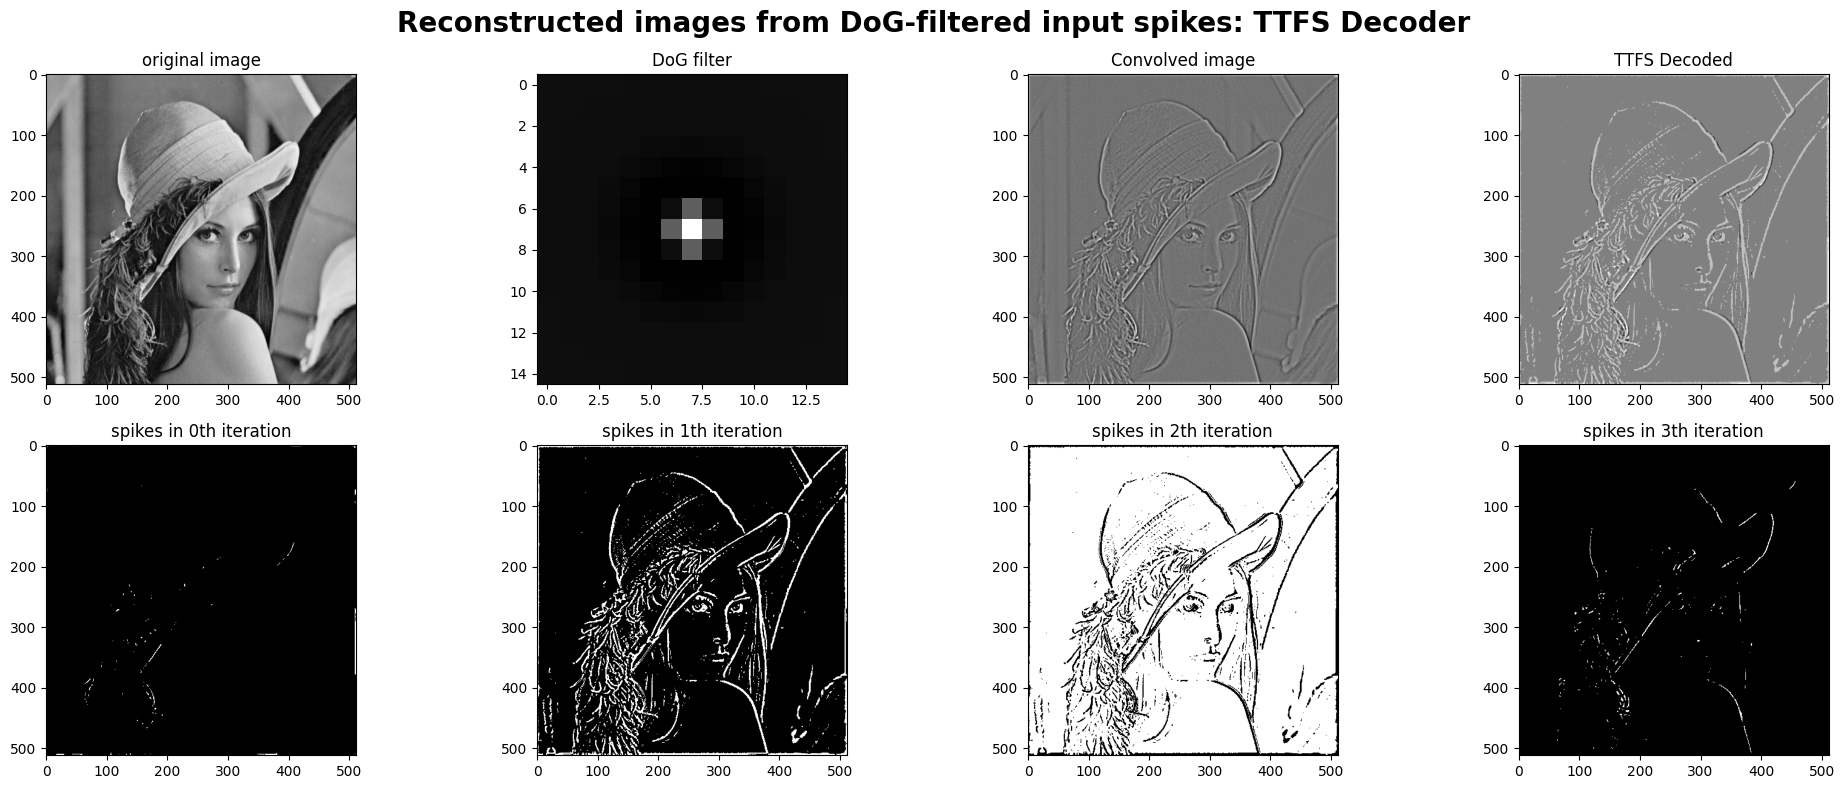

In [43]:
fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(2, 4, 1)
ax1.set_title('original image')
ax1.imshow(img_tensor.squeeze(0).squeeze(0), cmap='gray')

ax2 = fig.add_subplot(2, 4, 2)
ax2.set_title('DoG filter')
ax2.imshow(dog_kernel_low.squeeze(0).squeeze(0), cmap='gray')

ax3 = fig.add_subplot(2, 4, 3)
ax3.set_title('Convolved image')
ax3.imshow(dog_filter_low(img_tensor).squeeze(0).squeeze(0), cmap='gray')

ax4 = fig.add_subplot(2, 4, 4)
ax4.set_title('TTFS Decoded')
ax4.imshow(ttfs_decoder(encoded_ttfs_dog), cmap='gray')


for i in range(4):
    ax = fig.add_subplot(2, 4, i+5)
    ax.set_title(f'spikes in {i}th iteration')
    ax.imshow(encoded_ttfs_dog[i], cmap='gray')

fig.suptitle("Reconstructed images from DoG-filtered input spikes: TTFS Decoder", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("../report/plots/part1-compare-ttfs-dog-decoded.pdf")
plt.show()

### b) Poisson(Bonus)

In [51]:
INSTANCE_DURATION = 5
POISSON_RATIO = 5 / 15

In [52]:
poisson_decoder = PoissonDecoder(time_window=INSTANCE_DURATION, ratio=POISSON_RATIO)

In [53]:
transformation = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        dog_filter,
        MinMaxNormalizer(),
        transforms.Resize((1000, 1000)),
        SqueezeTransform(dim=0),
        Poisson(time_window=INSTANCE_DURATION, ratio=POISSON_RATIO),
    ]
)
encoded_poisson_dog = transformation(img)

In [54]:
transformation = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        gabor_filter,
        MinMaxNormalizer(),
        transforms.Resize((512, 512)),
        SqueezeTransform(dim=0),
        Poisson(time_window=INSTANCE_DURATION, ratio=POISSON_RATIO),
    ]
)
encoded_poisson_gabor = transformation(img)

### DoG filter

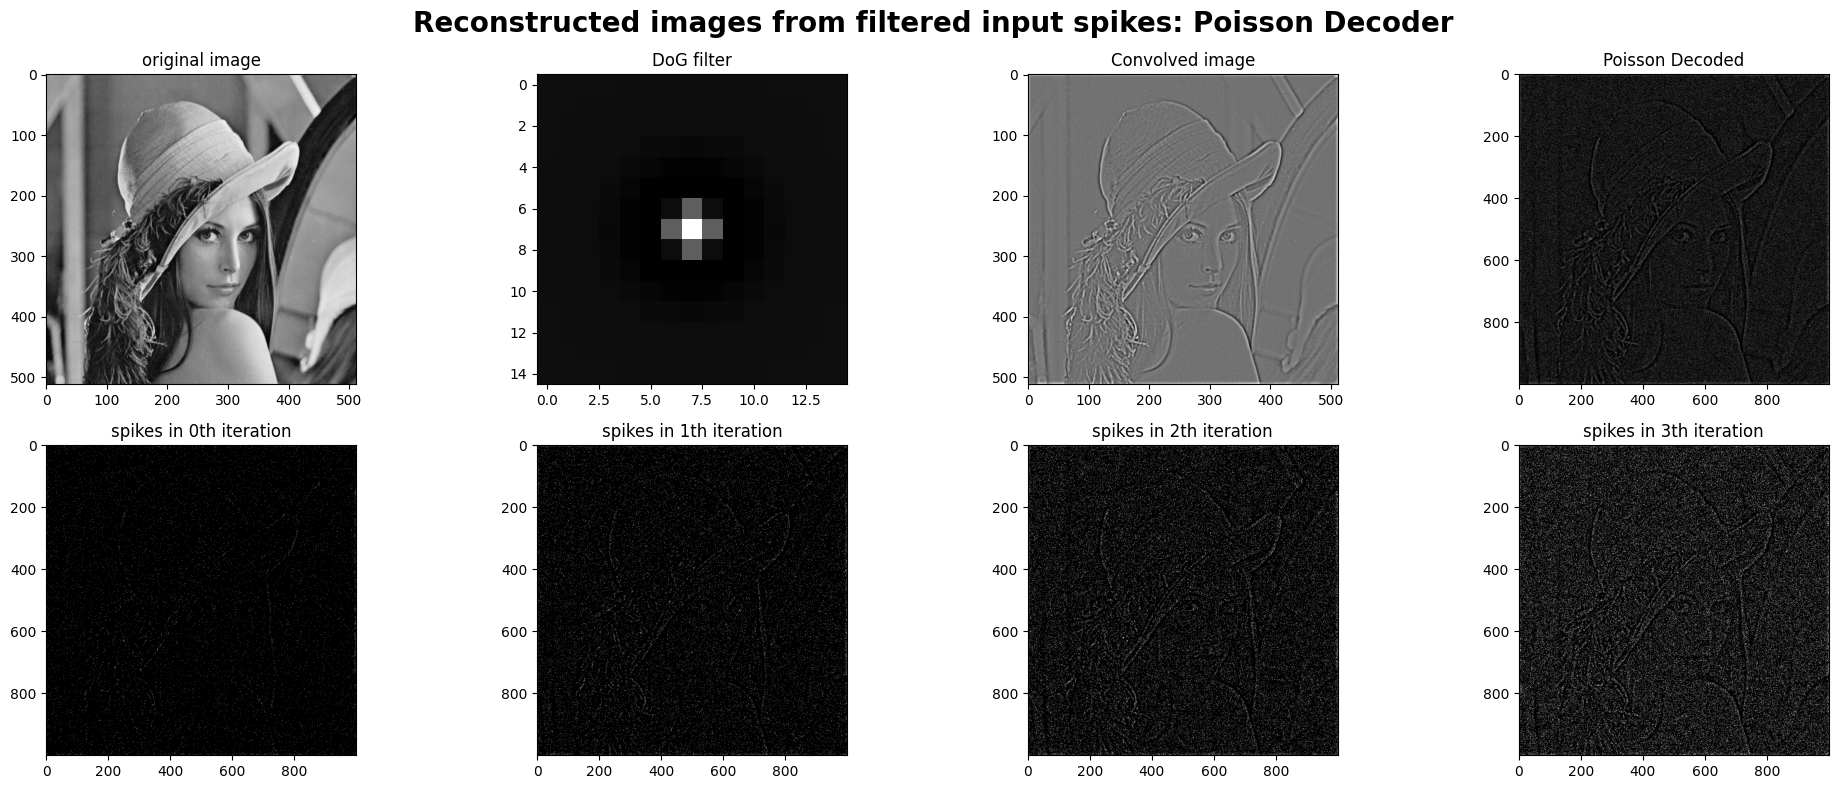

In [55]:
fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(2, 4, 1)
ax1.set_title('original image')
ax1.imshow(img_tensor.squeeze(0).squeeze(0), cmap='gray')

ax2 = fig.add_subplot(2, 4, 2)
ax2.set_title('DoG filter')
ax2.imshow(dog_kernel.squeeze(0).squeeze(0), cmap='gray')

ax3 = fig.add_subplot(2, 4, 3)
ax3.set_title('Convolved image')
ax3.imshow(dog_filter(img_tensor).squeeze(0).squeeze(0), cmap='gray')

ax4 = fig.add_subplot(2, 4, 4)
ax4.set_title('Poisson Decoded')
ax4.imshow(poisson_decoder(encoded_poisson_dog), cmap='gray')

for i in range(4):
    ax = fig.add_subplot(2, 4, i+5)
    ax.set_title(f'spikes in {i}th iteration')
    ax.imshow(encoded_poisson_dog[i], cmap='gray')    
    
fig.suptitle("Reconstructed images from filtered input spikes: Poisson Decoder", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("../report/plots/part1-compare-poisson-dog-decoded.pdf")
plt.show()

### Gabor filter

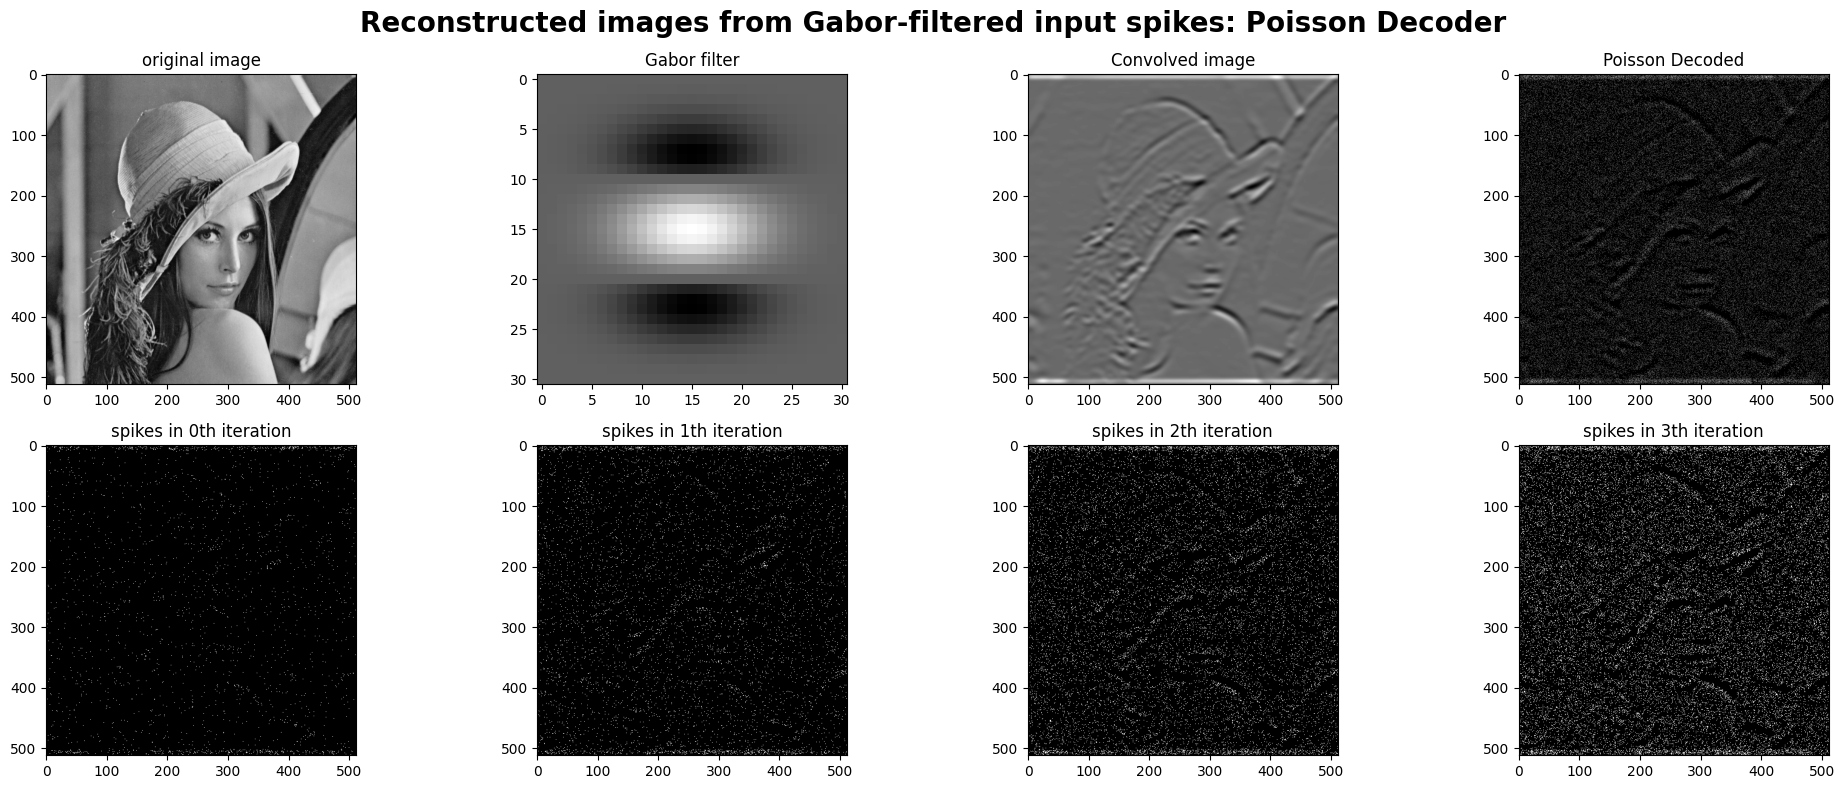

In [56]:
fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(2, 4, 1)
ax1.set_title('original image')
ax1.imshow(img_tensor.squeeze(0).squeeze(0), cmap='gray')

ax2 = fig.add_subplot(2, 4, 2)
ax2.set_title('Gabor filter')
ax2.imshow(gabor_kernel.squeeze(0).squeeze(0), cmap='gray')

ax3 = fig.add_subplot(2, 4, 3)
ax3.set_title('Convolved image')
ax3.imshow(gabor_filter(img_tensor).squeeze(0).squeeze(0), cmap='gray')

ax4 = fig.add_subplot(2, 4, 4)
ax4.set_title('Poisson Decoded')
ax4.imshow(poisson_decoder(encoded_poisson_gabor), cmap='gray')


for i in range(4):
    ax = fig.add_subplot(2, 4, i+5)
    ax.set_title(f'spikes in {i}th iteration')
    ax.imshow(encoded_poisson_gabor[i], cmap='gray')

fig.suptitle("Reconstructed images from Gabor-filtered input spikes: Poisson Decoder", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("../report/plots/part1-compare-poisson-gabor-decoded.pdf")
plt.show()